# Trade-off on downstream error: illustration with neural networks

In [1]:
from collections import defaultdict
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gegenbauer
from scipy import linalg as LA

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{mathtools}')
plt.rc('font', size=10, family='serif', serif='cm')


In [2]:
def rand_data(n, d):
    X = np.random.randn(n, d)
    return X / np.linalg.norm(X, axis=1)[:,None]

#### Symmetries

def block_cyclic(d, s):
    assert d % s == 0
    blocks = d // s
    sigma = np.arange(d)
    perm = sigma.copy()
    for shifts in product(*[range(s)] * blocks):
        for i, shift in enumerate(shifts):
            perm[i*s:(i+1)*s] = np.roll(sigma[i*s:(i+1)*s], shift)
        yield perm


def get_perms(group, d):
    if group == 'cyclic':
        return block_cyclic(d, d)
    elif group.startswith('loc_'): # (not a group... also only works with shift=1, rest is TODO)
        return [np.arange(d), np.roll(np.arange(d), -1), np.roll(np.arange(d), 1)]
    else:
        assert False


def symmetrize(f, group='perm'):
    def newf(X):
        numperm = 0
        out = 0.
        for perm in get_perms(group, X.shape[1]):
            out += f(X[:,perm])
            numperm += 1
        return out / numperm
    return newf

##### (downstream) target functions

def target_gegen(X, deg=3, group=None):
    d = X.shape[1]
    pk = gegenbauer(deg, d / 2 - 1)

    def f(X):
        return pk(X[:,0])
    return symmetrize(f, group=group)(X) if group else f(X)


In [3]:
#### Aruguments
max_shift = 5

d = 8
k = 20
n = 2000         # n = n_train + n_test
n_train = 300

In [4]:
np.random.seed(42)
n_views = 1 + 2 * max_shift  # identity + shifts in both directions
X = rand_data(n, d).astype(np.float32)

ys = []
ys.append(target_gegen(X, 1, group='loc_1'))
ys.append(target_gegen(X, 1, group='cyclic'))
ys.append(target_gegen(X, 2, group='loc_1'))
ys.append(target_gegen(X, 2, group='cyclic'))
ys.append(target_gegen(X, 3, group='loc_1'))
ys.append(target_gegen(X, 3, group='cyclic'))

ys_train = []
ys_test = []
for y in ys:
    ytr, yte = y[:n_train], y[n_train:]
    ys_train.append(ytr)
    ys_test.append(yte)

X_train, X_test = X[:n_train], X[n_train:]
X_aug = [X_train.copy()]
for shift in range(1, max_shift + 1):
    perm = np.roll(np.arange(d), shift)
    X_aug.append(X_train[:,perm])
    perm = np.roll(np.arange(d), -shift)
    X_aug.append(X_train[:,perm])

X_aug = np.concatenate(X_aug)
n_aug = X_aug.shape[0]

T = np.kron(1. - np.eye(n_views), np.eye(n_train))

In [5]:
### TODO add neural network code
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = "cuda"

T = torch.from_numpy(np.triu(T, k=1)).to(device)
xi = torch.from_numpy(X_aug).to(device)

pos_1, pos_2 = T.nonzero(as_tuple=True)
I = torch.eye(k, device=device, requires_grad=False)

X_train = torch.from_numpy(X_train).to(device)
X_test = torch.from_numpy(X_test).to(device)

for i in range(len(ys_train)):
    ys_train[i] = torch.from_numpy(ys_train[i]).to(device)
for i in range(len(ys_test)):
    ys_test[i] = torch.from_numpy(ys_test[i]).to(device)


In [6]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

num_hidden_layers = 2
hidden_dim = 200

learning_rate = 1e-3
weight_decay = 0
momentum = 0.9

nb_trials = 100
epochs = 5000
freq = 10

errors = torch.zeros((len(ys), epochs // freq, nb_trials))
norms = []
for yte in ys_test:
    norms.append(torch.mean(yte**2))

for m in range(nb_trials):
    model = nn.Sequential(*[
        nn.Linear(d, hidden_dim),
        nn.LayerNorm(hidden_dim),
        nn.ReLU(),
        # nn.BatchNorm1d(hidden_dim),
    ] + (num_hidden_layers - 1) * [
        nn.Linear(hidden_dim, hidden_dim),
        nn.LayerNorm(hidden_dim),
        nn.ReLU(),
        # nn.BatchNorm1d(hidden_dim),
    ] + [
        nn.Linear(hidden_dim, k)
    ]).to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum
    )
    for i in range(epochs):
        # eval
        if i % freq == 0:
            with torch.no_grad():
                phi_train = model(X_train)
                phi_test = model(X_test)

                C = phi_train.T @ phi_train
                # C += 1e-5 * n_train * np.eye(k)

                for j in range(len(ys_train)):
                    ytr = ys_train[j]
                    yte = ys_test[j]
                    preds = phi_test @ torch.linalg.solve(C, phi_train.T @ ytr)
                    err = F.mse_loss(preds, yte) / norms[j]
                    errors[j, i//freq, m] = err.item()
            if i and i % (50 * freq) == 0:
                print(m, inv.item(), reg.item())

        # forward
        z = model(xi)
        cov = torch.cov(z.t())
        reg = F.mse_loss(cov, I)
        reg *= k**2
        inv = F.mse_loss(z[pos_1], z[pos_2])
        inv *= k
        loss = inv + reg

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


0 0.47345635294914246 14.586841583251953
0 0.37591782212257385 13.615070343017578
0 0.7294816374778748 11.953964233398438
0 1.0435632467269897 7.558547019958496
0 0.925849199295044 5.12941312789917
0 0.6533480286598206 2.7751288414001465
0 0.6402754783630371 1.4247615337371826
0 0.5348373055458069 0.017856359481811523
0 0.3749062418937683 0.004576379433274269
1 0.5884938836097717 14.56180477142334
1 0.3950091004371643 13.838945388793945
1 0.31684815883636475 13.593329429626465
1 0.6590358018875122 11.699918746948242
1 0.969085693359375 7.934293746948242
1 0.7233315706253052 6.265275001525879
1 0.8352048397064209 3.963792324066162
1 0.6744832396507263 2.4396843910217285
1 0.6208723187446594 0.024189680814743042
2 0.48155009746551514 14.574308395385742
2 0.33114996552467346 13.692265510559082
2 0.4407377243041992 13.110735893249512
2 0.8236746788024902 9.797127723693848
2 0.718221127986908 7.212005615234375
2 0.6896108388900757 5.678964138031006
2 0.7610687613487244 3.6862521171569824
2 

In [2]:
from pathlib import Path
# np.save(Path.home() / 'errs.npy', errors.detach().cpu().numpy())

errs = np.load(Path.home() / 'errs.npy')
mean_errors = errs.mean(axis=2)
std_errors = errs.std(axis=2)
epochs = 5000
freq = 10

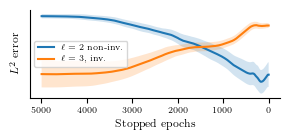

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(3,1.5))

labels = [r'$\ell=1$ non-inv.', r'$\ell=1$, inv.', r'$\ell=2$ non-inv.', r'$\ell=2$, inv.', r'$\ell=3$ non-inv.', r'$\ell=3$, inv.']
removed = [0,1, 3, 4]

tmp_x = freq * np.arange(epochs // freq)
for i, target in enumerate(labels):
    if i in removed:
        continue
    ax.plot(tmp_x, mean_errors[i], label=target)
    ax.fill_between(tmp_x, mean_errors[i] - .5*std_errors[i], mean_errors[i] + .5*std_errors[i], alpha=0.2)

ax.set_xlabel(r'Stopped epochs', fontsize=8)
ax.set_ylabel(r'$L^2$ error', fontsize=8)
ax.tick_params(axis="both", which="major", labelsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xscale('log')
ax.invert_xaxis()
# ax.set_yscale('log')
ax.set_yticks([])
ax.legend(fontsize=6, ncol=1)
fig.tight_layout()
fig.savefig('ssl_nn_spherical.pdf', bbox_inches='tight')